In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import calmap
import datetime
import tensorflow as tf

from datetime import date
from plotly.subplots import make_subplots
from itertools import cycle, product
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from pmdarima.arima import ARIMA as pmdARIMA
from pmdarima.arima import ADFTest, KPSSTest, auto_arima
from pmdarima.utils import diff_inv
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LSTM, Dense
from keras import Sequential
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.patches as mpatches
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.forecasting.stl import STLForecast

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
SEED = 84796315
PREVISOES = 5
EPOCAS = 30
BATCH_SIZE = 1000

EXECUTAR_GRID_SEARCH = False

# 1. Preparando Conjunto de Pedidos

In [3]:
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')

In [4]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAjustado = dtOrders.copy()

In [5]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAjustado[col] = pd.to_datetime(dtOrdersAjustado[col], format = '%Y-%m-%d %H:%M:%S')

In [6]:
# Dropando valores NA
dtOrdersAjustado = dtOrdersAjustado.dropna()

In [7]:
dtOrdersAjustado.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Iniciando Analise Seasonal

In [8]:
dtHistory = pd.to_datetime(dtOrdersAjustado['order_purchase_timestamp']).dt.date

start = dtHistory.min()
end = dtHistory.max()

idx = pd.date_range(start, end, normalize=True)

seriesHistory = dtHistory.value_counts(sort=False).sort_index().reindex(idx, fill_value=0)

dtHistory = pd.DataFrame(seriesHistory).reset_index()

Principais outliers identificados:

- 1 de setembro de 2016 a 31 de dezembro de 2016: Dados quase inexistentes
- 24 de novembro de 2017: Pico de venda devido ao evento da blackfriday
- 17 de agosto de 2017 a 17 de outubro de 2017: Queda repentina nos dados

In [9]:
dtHistory

index  order_purchase_timestamp
0   2016-09-15                         1
1   2016-09-16                         0
2   2016-09-17                         0
3   2016-09-18                         0
4   2016-09-19                         0
..         ...                       ...
709 2018-08-25                        69
710 2018-08-26                        73
711 2018-08-27                        66
712 2018-08-28                        39
713 2018-08-29                        11

[714 rows x 2 columns]

In [10]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

In [11]:
# Remove outliers
seriesHistory = seriesHistory[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_range = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))
dtHistory = pd.DataFrame(seriesHistory).reset_index()

In [12]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

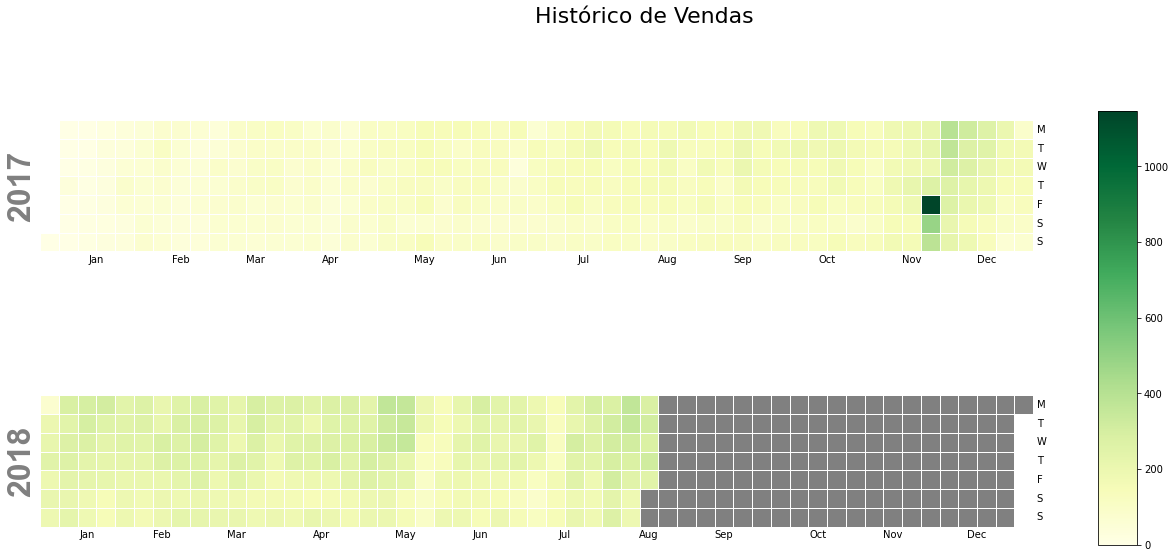

In [13]:
fig, caxs = calmap.calendarplot(seriesHistory, daylabels='MTWTFSS', fillcolor='grey',cmap='YlGn', fig_kws=dict(figsize=(18, 9)))
fig.suptitle('Histórico de Vendas', fontsize=22)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax=cbar_ax)

plt.show()

In [14]:
def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    
    # Nome de cada um dos subplots
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            ax.legend(legend, frameon=False)

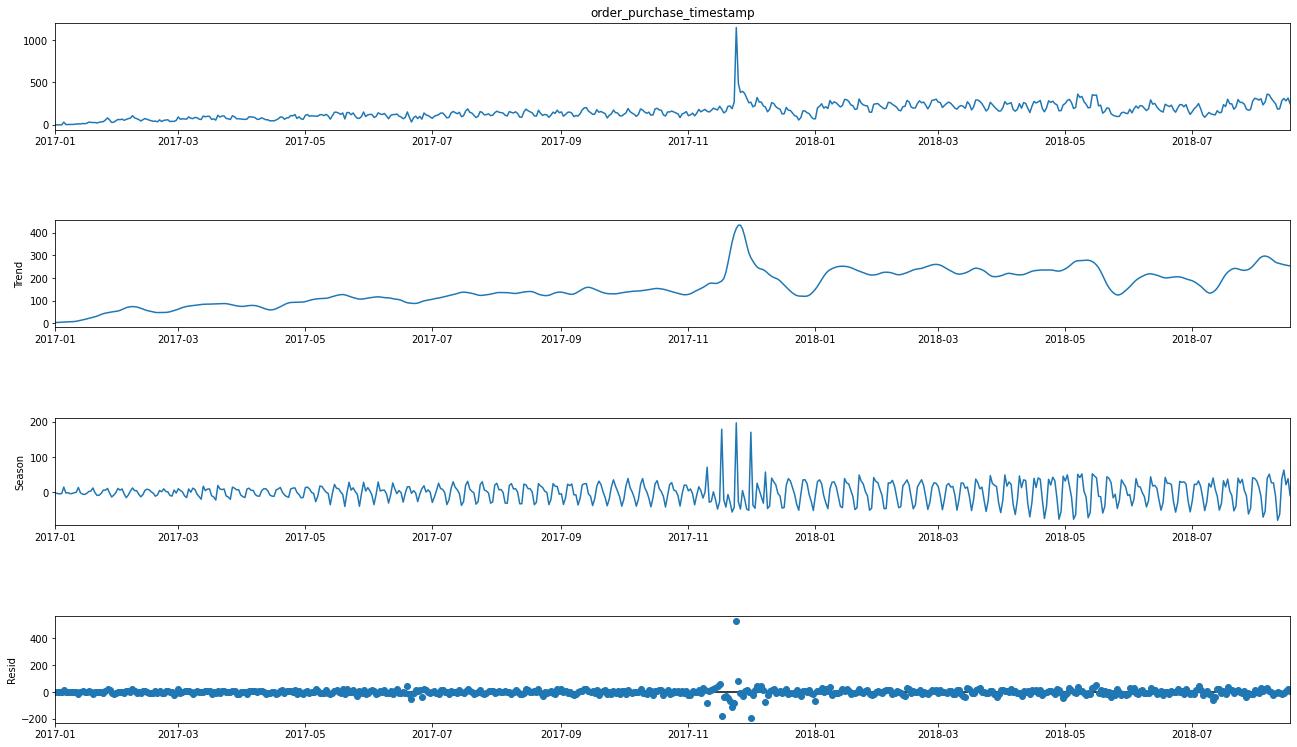

In [15]:
stl = STL(seriesHistory)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((20, 12))
plt.show()

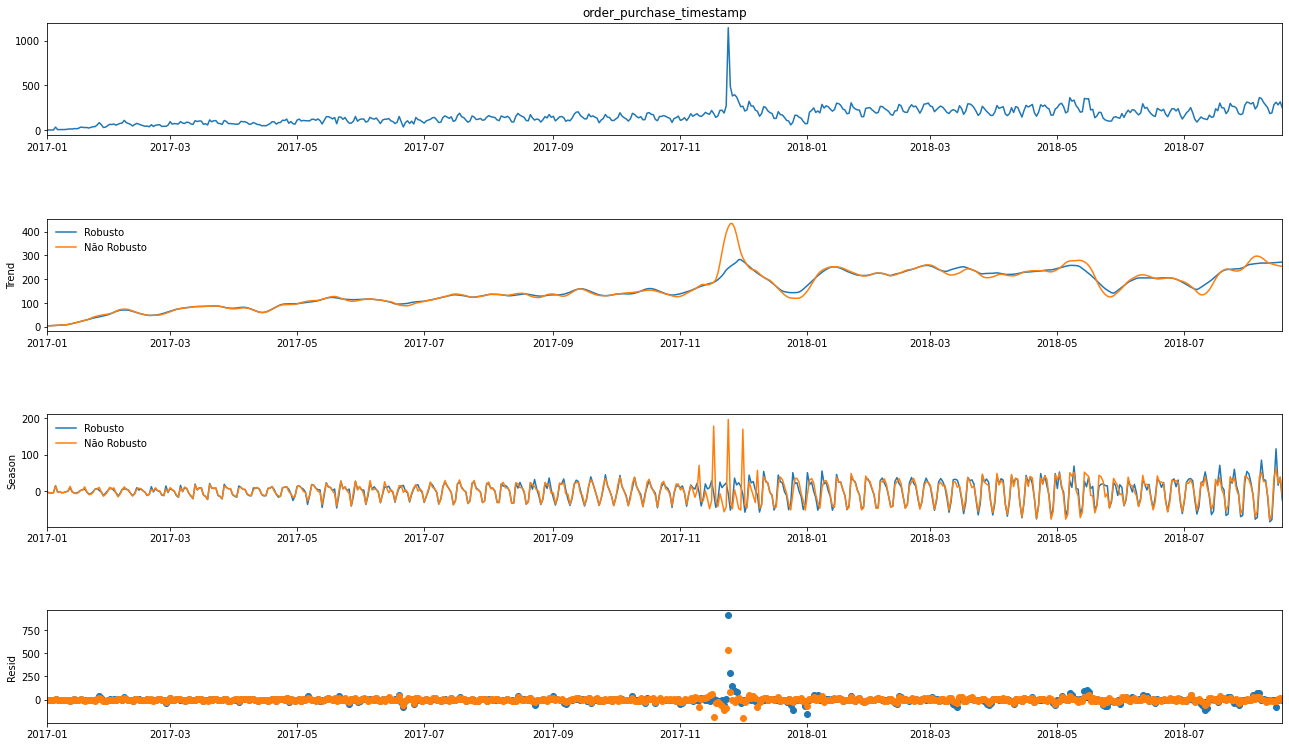

In [16]:
stl = STL(seriesHistory, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches((20, 12))
res_non_robust = STL(seriesHistory, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robusto", "Não Robusto"])

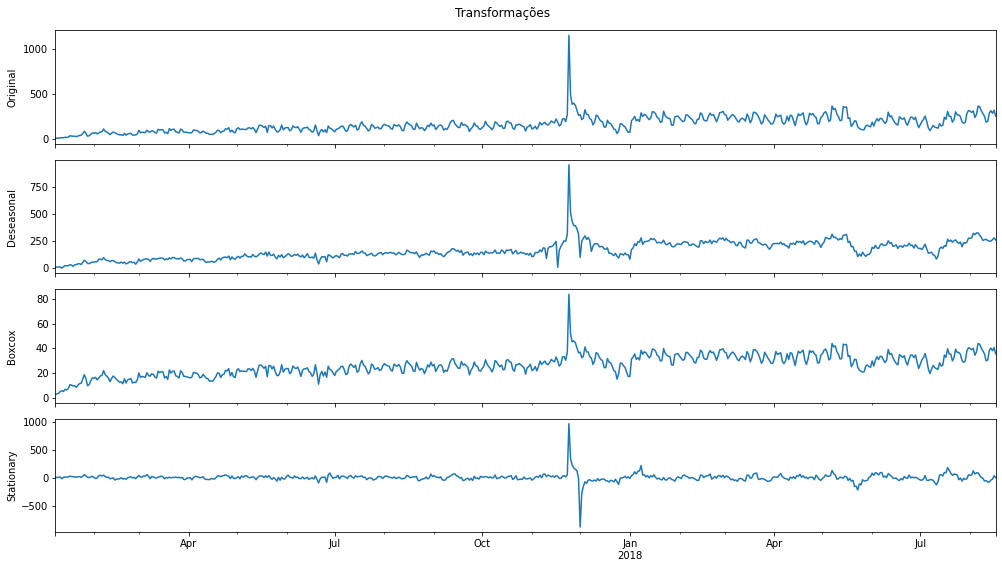

In [17]:
stl = STL(seriesHistory)
res = stl.fit()
deseasonal = res.observed - res.seasonal

bc_history, lmbda = boxcox(seriesHistory+1)
bc_history = pd.Series(bc_history, index=seriesHistory.index)

diff_history = seriesHistory.diff(7).dropna()
xi = seriesHistory.iloc[:7]

fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))
seriesHistory.plot(ax=axs[0])
axs[0].set_ylabel('Original')
deseasonal.plot(ax=axs[1])
axs[1].set_ylabel('Deseasonal')
bc_history.plot(ax=axs[2])
axs[2].set_ylabel('Boxcox')
diff_history.plot(ax=axs[3])
axs[3].set_ylabel('Stationary')
fig.align_ylabels()
fig.suptitle('Transformações')
plt.tight_layout()
plt.show()

## 2.1 Testes

Os testes abaixo concluiram:

- ADF: O teste aceita a hipótese alternativa em que a série é estácionária.

- KPSS: O teste aceita a hipótese alternativa em que a série não é estácionária.

### 2.1.1 ADF:

ADF teste:

- Hipótese Nula(HO): A série possui unit root ou não é estacionária.
- Hipótese Alternativa(HA):  A série não possui unit root ou é estacionária.

In [18]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')

    print(f'ADF: {result[0]}')
    print(f'steps: {result[1]}')
    print(f'p-value: {result[1]}')

    for key, value in result[4].items():
        print('\nValor Critico:')
        print(f'   {key}: {value}')    

In [19]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(seriesHistory)

(0.01, False)

In [20]:
adf_test(seriesHistory)

ADF: -2.6163082378564737
steps: 0.0896733120129114
p-value: 0.0896733120129114

Valor Critico:
   1%: -3.441694608475642

Valor Critico:
   5%: -2.866544718556839

Valor Critico:
   10%: -2.5694353738653684


In [21]:
adf.should_diff(diff_history)

(0.01, False)

In [22]:
adf_test(diff_history)

ADF: -6.80160615209054
steps: 2.229745766642107e-09
p-value: 2.229745766642107e-09

Valor Critico:
   1%: -3.441834071558759

Valor Critico:
   5%: -2.8666061267054626

Valor Critico:
   10%: -2.569468095872659


### 2.1.2 KPSS:

KPSS teste:

- Hipótese Nula (HO): A série não possui unit root ou é estacionária.
- Hipótese Alternativa(HA): A série possui unit root ou não é estacionária.

In [23]:
kpss = KPSSTest(alpha = 0.05)
kpss.should_diff(seriesHistory)

(0.01, True)

In [24]:
kpss.should_diff(diff_history)

(0.1, False)

# 3. Modelagem

Toda a etapa de modelagem será considerada com 5 passos a frente de previsão.

In [25]:
result = pd.DataFrame(columns=['Algorithm', 'MSE', 'RMSE', 'MAE', 'Mean_Real_Value', 'Mean_Predict_Value'])

In [26]:
split_range = TimeSeriesSplit(n_splits = 8, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

In [27]:
def record(result, algorithm, mse = -1, rmse = -1, mae = -1, mrv = -1, mpv = -1, show = True):
    new = pd.DataFrame(dict(Algorithm = algorithm, MSE = mse, RMSE = rmse, MAE = mae, Mean_Real_Value = mrv,\
                            Mean_Predict_Value = mpv), index=[0])
    result = pd.concat([result, new], ignore_index=True)
    
    if show:
        display(result)
    
    return result

In [28]:
def plot(index, pred, mse, title, fig = None, ax = None, ylabel = ''):
    global seriesHistory
    
    empty_fig = fig is None
    
    if empty_fig:
        fig, ax = plt.subplots(figsize=(13, 6))
    else: 
        ax.set_ylabel(ylabel)
                
    ax.set_title(title)    
    patch_ = mpatches.Patch(color = 'white', label = f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles = [patch_], loc = 'upper left', fancybox = True, framealpha = 0.7,  handlelength = 0)
    ax.add_artist(L1)
    
    sns.lineplot(x = seriesHistory.index, y = seriesHistory, label = 'Real', ax = ax)
    sns.lineplot(x = index, y = pred, label = 'Previsto', ax = ax)
    ax.axvline(x = index[0], color = 'red')
    ax.legend(loc = 'upper right')
    
    if empty_fig:
        plt.show()
    else:
        return fig

In [29]:
'''
Correção da função diff_inv original:
https://github.com/alkaline-ml/pmdarima/issues/410
'''

def diff_inv_fix(x_diff, xi, column, steps = 1):
    total_len = len(x_diff) + len(xi)
    
    ix = pd.date_range(xi.index[0], periods = total_len)  
    inv = diff_inv(x_diff, steps, xi = xi) + np.fromiter(cycle(xi), count = total_len, dtype = float)  
    inv = pd.Series(inv, index = ix, name = column)
    
    return inv

## 3.1 TSR (Time Series Regression)

In [30]:
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.tight_layout()
plt.close()

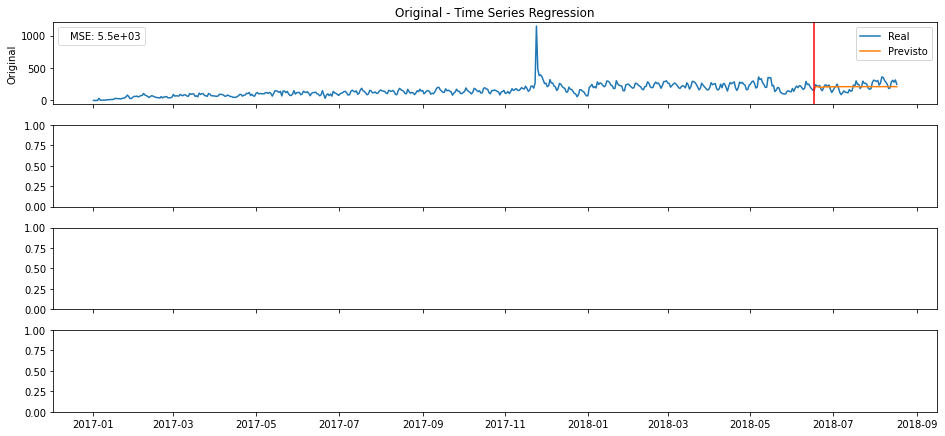

In [31]:
title = 'Original - Time Series Regression'
data = seriesHistory.copy()

mse = []
rmse = []
mae = []
mrv = []
mpv = []

for train_id, test_id in split_range.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    
    gen = TimeseriesGenerator(train, train, PREVISOES, batch_size = BATCH_SIZE)
    
    X_train = gen[0][0]
    y_train = gen[0][1]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-PREVISOES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
        y_pred[i] = forecast
        
    mse.append(mean_squared_error(y_test, y_pred, squared = True))
    rmse.append(mean_squared_error(y_test, y_pred, squared = False))
    mae.append(mean_absolute_error(y_test, y_pred))
    mrv.append(np.mean(y_test))
    mpv.append(np.mean(y_pred))

result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(y_test.index, y_pred, mse, title, figs, axs[0], 'Original')

## 3.2 STL Deseasonal - TSR (Time Series Regression)

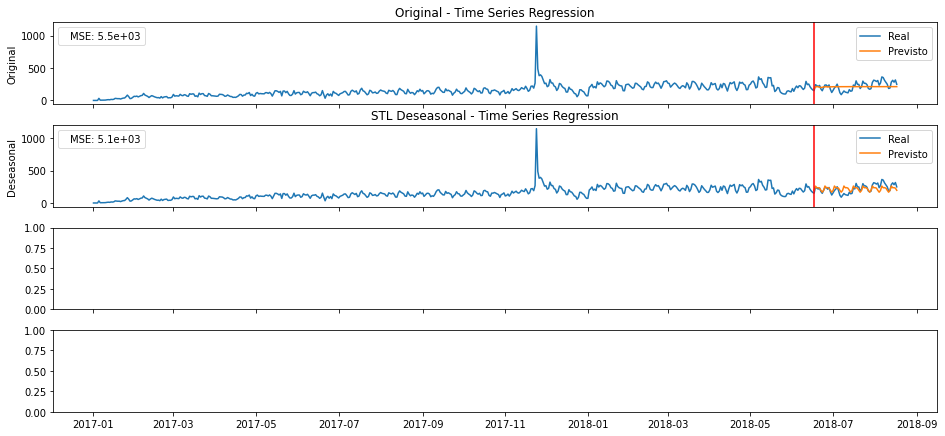

In [32]:
title = 'STL Deseasonal - Time Series Regression'
data = deseasonal.copy()

mse = []
rmse = []
mae = []
mrv = []
mpv = []

for train_id, test_id in split_range.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    
    gen = TimeseriesGenerator(train, train, PREVISOES, batch_size = BATCH_SIZE)
    
    X_train = gen[0][0]
    y_train = gen[0][1]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-PREVISOES:].reshape(1, -1)
    y_pred = np.empty(y_test.shape[0])
    
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
        y_pred[i] = forecast
    
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    y_pred = y_pred + np.fromiter(cycle(last_seasonal), count = y_pred.shape[0], dtype = float)
    y_test = y_test + res.seasonal.reindex_like(y_test)
    
    mse.append(mean_squared_error(y_test, y_pred, squared = True))
    rmse.append(mean_squared_error(y_test, y_pred, squared = False))
    mae.append(mean_absolute_error(y_test, y_pred))
    mrv.append(np.mean(y_test))
    mpv.append(np.mean(y_pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(y_test.index, y_pred, mse, title, figs, axs[1], 'Deseasonal')

## 3.3 STL BoxCox - TSR (Time Series Regression)

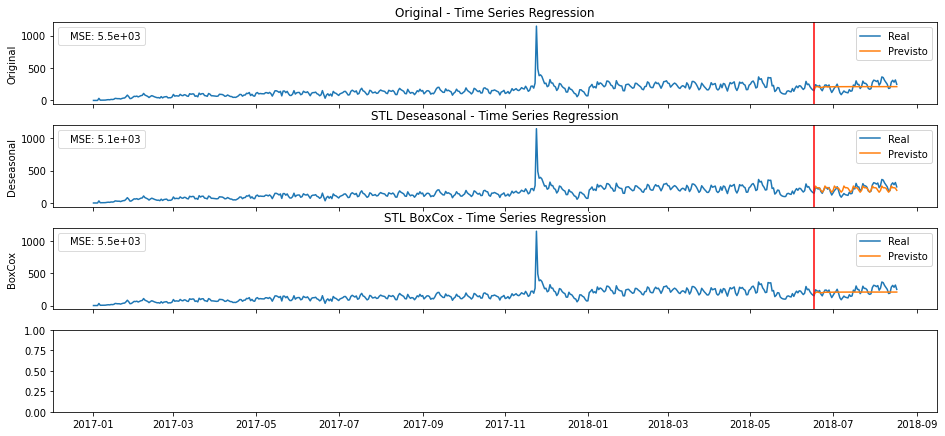

In [33]:
title = 'STL BoxCox - Time Series Regression'
data = bc_history.copy()

mse = []
rmse = []
mae = []
mrv = []
mpv = []

for train_id, test_id in split_range.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    
    gen = TimeseriesGenerator(train, train, PREVISOES, batch_size = BATCH_SIZE)
    
    X_train = gen[0][0]
    y_train = gen[0][1]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-PREVISOES:].reshape(1, -1)
    y_pred = np.empty(y_test.shape[0])
    
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
        y_pred[i] = forecast
    
    y_pred = inv_boxcox1p(y_pred, lmbda)
    y_test = inv_boxcox1p(y_test, lmbda)
    
    mse.append(mean_squared_error(y_test, y_pred, squared = True))
    rmse.append(mean_squared_error(y_test, y_pred, squared = False))
    mae.append(mean_absolute_error(y_test, y_pred))
    mrv.append(np.mean(y_test))
    mpv.append(np.mean(y_pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(y_test.index, y_pred, mse, title, figs, axs[2], 'BoxCox')

## 3.4 Stationary - TSR (Time Series Regression)

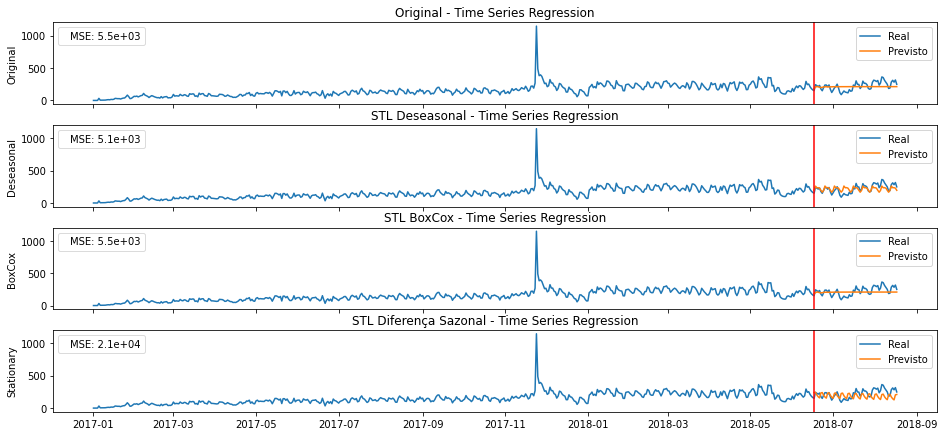

In [34]:
title = 'STL Diferença Sazonal - Time Series Regression'
data = diff_history.copy()

mse = []
rmse = []
mae = []
mrv = []
mpv = []

for train_id, test_id in split_range.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    
    gen = TimeseriesGenerator(train, train, PREVISOES, batch_size = BATCH_SIZE)
    
    X_train = gen[0][0]
    y_train = gen[0][1]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-PREVISOES:].reshape(1, -1)
    y_pred = np.empty(y_test.shape[0])
    
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
        y_pred[i] = forecast
    
    xi = seriesHistory.reindex_like(train).tail(PREVISOES)
    y_pred = diff_inv_fix(y_pred, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
    y_test = diff_inv_fix(y_test, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
    
    mse.append(mean_squared_error(y_test, y_pred, squared = True))
    rmse.append(mean_squared_error(y_test, y_pred, squared = False))
    mae.append(mean_absolute_error(y_test, y_pred))
    mrv.append(np.mean(y_test))
    mpv.append(np.mean(y_pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(y_test.index, y_pred, mse, title, figs, axs[3], 'Stationary')

In [35]:
result

Algorithm           MSE        RMSE  \
0               Original - Time Series Regression   5485.688752   63.032946   
1         STL Deseasonal - Time Series Regression   5070.936469   57.842363   
2             STL BoxCox - Time Series Regression   5531.781002   63.453289   
3  STL Diferença Sazonal - Time Series Regression  20765.011179  123.412496   

         MAE  Mean_Real_Value  Mean_Predict_Value  
0  45.057261       179.560484          164.066513  
1  39.592783       179.560484          166.267257  
2  45.576572       179.560484          160.984010  
3  88.116806       181.296371          175.123977

## 3.5 Exponential Smoothing

In [36]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    r_params = [True, False]
    method_params = ['L-BFGS-B' , 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'bh', 'ls']
    
    # create config instances
    for t in t_params:
        for s in s_params:
            for p in p_params:
                for r in r_params:
                    for m in method_params:
                        cfg = [t, s, p, r, m]
                        models.append(cfg)
    return models

In [37]:
def GSES(alpha, beta, gamma, optimized):
    global seriesHistory
    data = seriesHistory.copy()
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = (
            ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=PREVISOES)
            .fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, method='ls',\
                 optimized = optimized)
        )
        
        pred = ES.forecast(test.shape[0])
        mse.append(mean_squared_error(pred, test))
        
    return np.mean(mse)

In [38]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [39]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(x.alpha, x.beta, x.gamma, False), axis = 1)

Wall time: 32 s


In [40]:
tuning.query('mse == mse.min()')

alpha  beta  gamma          mse
113    0.1   0.1    0.3  5832.376838

In [41]:
def GSES(trend, season, periods, bias, method, optimized):
    global seriesHistory
    data = seriesHistory.copy()
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend = trend, seasonal = season, seasonal_periods = periods)
                    .fit(remove_bias = bias, method = method, optimized = optimized)
                )
        
                pred = ES.forecast(test.shape[0])
                mse.append(mean_squared_error(pred, test, squared = True))
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [42]:
params_ = exp_smoothing_configs([PREVISOES])

In [43]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [44]:
len(tuning2)

126

In [45]:
tuning2.head()

trend season  periods  bias        method
0   add    add        5  True      L-BFGS-B
1   add    add        5  True           TNC
2   add    add        5  True         SLSQP
3   add    add        5  True        Powell
4   add    add        5  True  trust-constr

In [46]:
%%time
if EXECUTAR_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSES(x.trend, x.season, x.periods, x.bias, x.method, True), axis = 1)

Wall time: 0 ns


In [47]:
if EXECUTAR_GRID_SEARCH:
    tuning2.query('mse == mse.min() and mse != -1')

In [48]:
title = 'Original - Exponential Smoothing'

figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

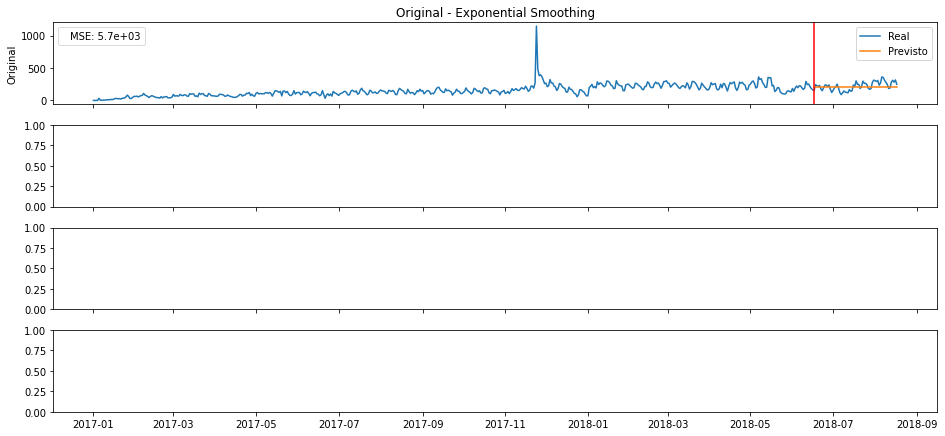

In [49]:
mse = []
rmse = []
mae = []
mrv = []
mpv = []

data = seriesHistory.copy()

for train_id, test_id in split_range.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ES = (
        ExponentialSmoothing(train, trend=None, seasonal=None, seasonal_periods=PREVISOES)
        .fit(remove_bias = False, smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.3, method='Powell')
    )
    pred = ES.forecast(test.shape[0])
    
    mse.append(mean_squared_error(pred, test))
    
    mse.append(mean_squared_error(pred, test, squared = True))
    rmse.append(mean_squared_error(pred, test, squared = False))
    mae.append(mean_absolute_error(pred, test))
    mrv.append(np.mean(test))
    mpv.append(np.mean(pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(test.index, pred, mse, title, figs, axs[0], 'Original')

In [50]:
result

Algorithm           MSE        RMSE  \
0               Original - Time Series Regression   5485.688752   63.032946   
1         STL Deseasonal - Time Series Regression   5070.936469   57.842363   
2             STL BoxCox - Time Series Regression   5531.781002   63.453289   
3  STL Diferença Sazonal - Time Series Regression  20765.011179  123.412496   
4                Original - Exponential Smoothing   5675.040573   63.891457   

         MAE  Mean_Real_Value  Mean_Predict_Value  
0  45.057261       179.560484          164.066513  
1  39.592783       179.560484          166.267257  
2  45.576572       179.560484          160.984010  
3  88.116806       181.296371          175.123977  
4  45.907233       179.560484          170.060434

## 3.6 Deseasonal - Exponential Smoothing

In [51]:
def GSES(data, alpha, beta, gamma, optimized):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = ExponentialSmoothing
        model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=PREVISOES)
        
        fit_kwargs = dict(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls',\
                          optimized = optimized)
        
        stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
        pred = stlf.forecast(test.shape[0])
        
        
        mse.append(mean_squared_error(pred, test))
        
    return np.mean(mse)

In [52]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [53]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(deseasonal.copy(), x.alpha, x.beta, x.gamma, False), axis=1)

Wall time: 44 s


In [54]:
tuning.query('mse == mse.min()')

alpha  beta  gamma          mse
114    0.1   0.1    0.4  4823.778306

In [55]:
def GSES(data, trend, season, periods, bias, method, optimized):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                
                ES = ExponentialSmoothing
                model_kwargs = dict(trend = trend, seasonal = season, seasonal_periods = periods)

                fit_kwargs = dict(remove_bias = bias, method = method, optimized = optimized)

                stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
                pred = stlf.forecast(test.shape[0])

                mse.append(mean_squared_error(pred, test, squared = True))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [56]:
params_ = exp_smoothing_configs([PREVISOES])

In [57]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [58]:
%%time
if EXECUTAR_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSES(deseasonal.copy(), x.trend, x.season, x.periods, x.bias, x.method, True), axis = 1)

Wall time: 0 ns


In [59]:
if EXECUTAR_GRID_SEARCH:
    tuning2.query('mse == mse.min() and mse != -1')

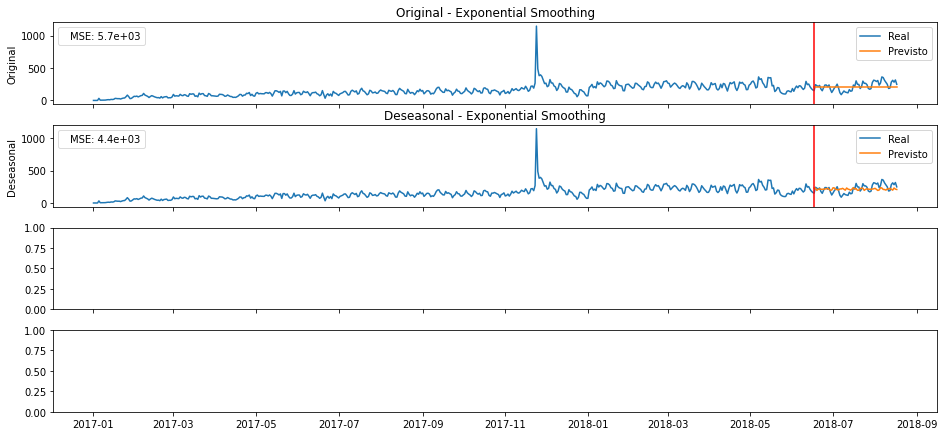

In [60]:
mse = []
rmse = []
mae = []
mrv = []
mpv = []
data = deseasonal.copy()
title = 'Deseasonal - Exponential Smoothing'

for train_id, test_id in split_range.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    
    ES = ExponentialSmoothing
    model_kwargs = dict(trend=None, seasonal='add', seasonal_periods=PREVISOES)
    fit_kwargs = dict(remove_bias = True, smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.4, method='ls')
    
    stlf = STLForecast(train, ES, model_kwargs=model_kwargs).fit(fit_kwargs=fit_kwargs)
    pred = stlf.forecast(test.shape[0])
    
    mse.append(mean_squared_error(pred, test, squared = True))
    rmse.append(mean_squared_error(pred, test, squared = False))
    mae.append(mean_absolute_error(pred, test))
    mrv.append(np.mean(test))
    mpv.append(np.mean(pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(test.index, pred, mse, title, figs, axs[1], 'Deseasonal')

## 3.7 BoxCox - Exponential Smoothing

In [65]:
def GSES(data, alpha, beta, gamma, optimized):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        ES = (
            ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=PREVISOES)
            .fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls', optimized = optimized)
        )
        pred = ES.forecast(test.shape[0])
        pred = inv_boxcox1p(pred, lmbda)
        test = inv_boxcox1p(test, lmbda)
        try:
            mse.append(mean_squared_error(pred, test))
        except ValueError:
            mse.append(-1)
    return np.mean(mse)

In [66]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [67]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(bc_history.copy(), x.alpha, x.beta, x.gamma, False), axis=1)

Wall time: 13.4 s


In [68]:
tuning.query('mse == mse.min() and mse != -1'')

alpha  beta  gamma          mse
113    0.1   0.1    0.3  5549.249911

In [69]:
def GSES(data, trend, season, periods, bias, method, optimized):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                
                ES = (
                    ExponentialSmoothing(train, trend=trend, seasonal=season, seasonal_periods=periods)
                    .fit(remove_bias = bias, method=method, optimized = optimized)
                )
                pred = ES.forecast(test.shape[0])
                pred = inv_boxcox1p(pred, lmbda)
                test = inv_boxcox1p(test, lmbda)

                mse.append(mean_squared_error(pred, test, squared = True))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [70]:
params_ = exp_smoothing_configs([PREVISOES])

In [71]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [72]:
%%time
if EXECUTAR_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSES(bc_history.copy(), x.trend, x.season, x.periods, x.bias, x.method, True), axis = 1)

Wall time: 0 ns


In [73]:
if EXECUTAR_GRID_SEARCH:
    tuning2.query('mse == mse.min() and mse != -1')

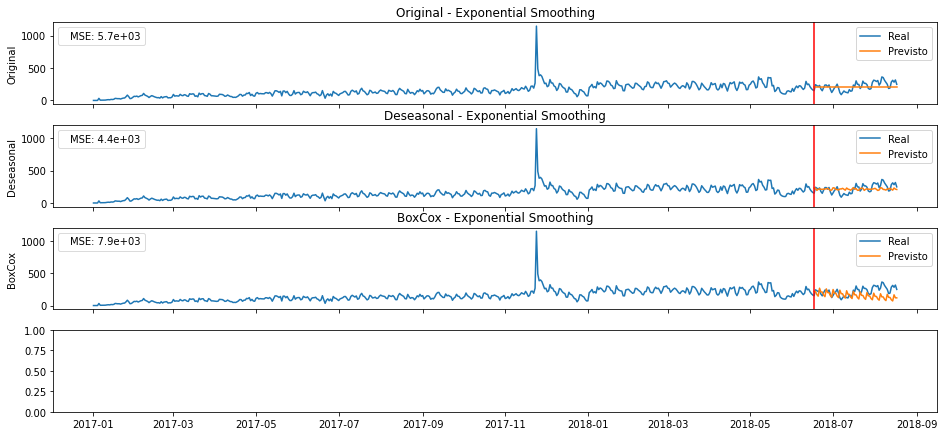

In [74]:
mse = []
rmse = []
mae = []
mrv = []
mpv = []

data = bc_history.copy()
title = 'BoxCox - Exponential Smoothing'

for train_id, test_id in split_range.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=PREVISOES)
        .fit(smoothing_level=0.2, smoothing_trend=0, smoothing_seasonal=0.9, method='ls')
    )
    pred = ES.forecast(test.shape[0])
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    
    mse.append(mean_squared_error(pred, test, squared = True))
    rmse.append(mean_squared_error(pred, test, squared = False))
    mae.append(mean_absolute_error(pred, test))
    mrv.append(np.mean(test))
    mpv.append(np.mean(pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(test.index, pred, mse, title, figs, axs[2], 'BoxCox')

## 3.7 Seasonal - Exponential Smoothing

In [79]:
def GSES(data, alpha, beta, gamma):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        
        try:
            train, test = data.iloc[train_id], data.iloc[test_id]
            ES = (
                ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
                .fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, method='ls')
            )
            pred = ES.forecast(test.shape[0])
            xi = seriesHistory.reindex_like(train).tail(PREVISOES)
            pred = diff_inv_fix(pred, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
            test = diff_inv_fix(test, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]

            mse.append(mean_squared_error(pred, test), squared = True)
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [80]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [81]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(diff_history.copy(), x.alpha, x.beta, x.gamma), axis=1)

Wall time: 1min 8s


In [82]:
tuning.query('mse == mse.min() and mse != -1')

Empty DataFrame
Columns: [alpha, beta, gamma, mse]
Index: []

In [83]:
def GSES(data, trend, season, periods, bias, method, optimized):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend=trend, seasonal=season, seasonal_periods=periods)
                    .fit(remove_bias = bias, method=method, optimized = optimized)
                )
                pred = ES.forecast(test.shape[0])
                xi = seriesHistory.reindex_like(train).tail(PREVISOES)
                pred = diff_inv_fix(pred, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
                test = diff_inv_fix(test, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]

                mse.append(mean_squared_error(pred, test, squared = True))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [84]:
params_ = exp_smoothing_configs([PREVISOES])

In [85]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [86]:
%%time
if EXECUTAR_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSES(diff_history.copy(), x.trend, x.season, x.periods, x.bias, x.method, True), axis = 1)

Wall time: 0 ns


In [87]:
if EXECUTAR_GRID_SEARCH:
    tuning2.query('mse == mse.min() and mse != -1')

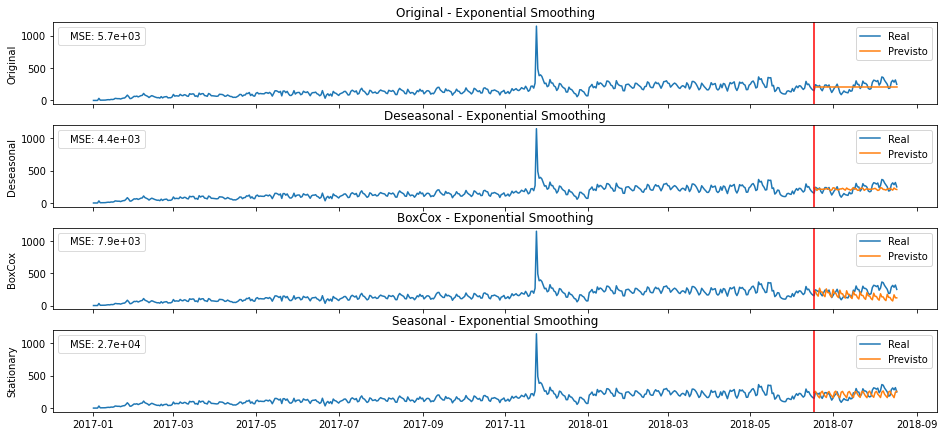

In [88]:
mse = []
rmse = []
mae = []
mrv = []
mpv = []

data = diff_history.copy()
title = 'Seasonal - Exponential Smoothing'

for train_id, test_id in split_range.split(data):
    train, test = data.iloc[train_id], data.iloc[test_id]
    ES = (
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
        .fit(smoothing_level=0, smoothing_trend=0.3, smoothing_seasonal=0, method='ls')
    )
    pred = ES.forecast(test.shape[0])
    xi = seriesHistory.reindex_like(train).tail(PREVISOES)
    pred = diff_inv_fix(pred, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
    test = diff_inv_fix(test, xi, 'order_purchase_timestamp', PREVISOES).iloc[PREVISOES:]
    mse.append(mean_squared_error(pred, test, squared = True))
    rmse.append(mean_squared_error(pred, test, squared = False))
    mae.append(mean_absolute_error(pred, test))
    mrv.append(np.mean(test))
    mpv.append(np.mean(pred))
    
result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
plot(test.index, pred, mse, title, figs, axs[3], 'Stationary')

In [89]:
result

Algorithm           MSE        RMSE  \
0               Original - Time Series Regression   5485.688752   63.032946   
1         STL Deseasonal - Time Series Regression   5070.936469   57.842363   
2             STL BoxCox - Time Series Regression   5531.781002   63.453289   
3  STL Diferença Sazonal - Time Series Regression  20765.011179  123.412496   
4                Original - Exponential Smoothing   5675.040573   63.891457   
5              Deseasonal - Exponential Smoothing   4361.850691   53.380658   
6                  BoxCox - Exponential Smoothing   7896.632144   82.610180   
7                Seasonal - Exponential Smoothing  26707.475240  148.337794   

          MAE  Mean_Real_Value  Mean_Predict_Value  
0   45.057261       179.560484          164.066513  
1   39.592783       179.560484          166.267257  
2   45.576572       179.560484          160.984010  
3   88.116806       181.296371          175.123977  
4   45.907233       179.560484          170.060434  
5   37.993929       179.428217          171.664982  
6   62.171696       179.560484          173.618624  
7  106.433799       181.296371          171.802182